# Form Recognition in Spark Ocr

End-to-end form recognition using VisualDocumentNerV2 and FormRelationExtractor.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/3.2.SparkOcrFormRecognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs==5.1.6

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.settings.enforce_versions=True
nlp.install(refresh_install=True, visual=True)

In [4]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

## Start spark session

In [5]:
from johnsnowlabs import visual, nlp
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8356 (4).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.1.1, 💊Spark-Healthcare==5.1.1, 🕶Spark-OCR==5.0.2, running on ⚡ PySpark==3.1.2


## Load image


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


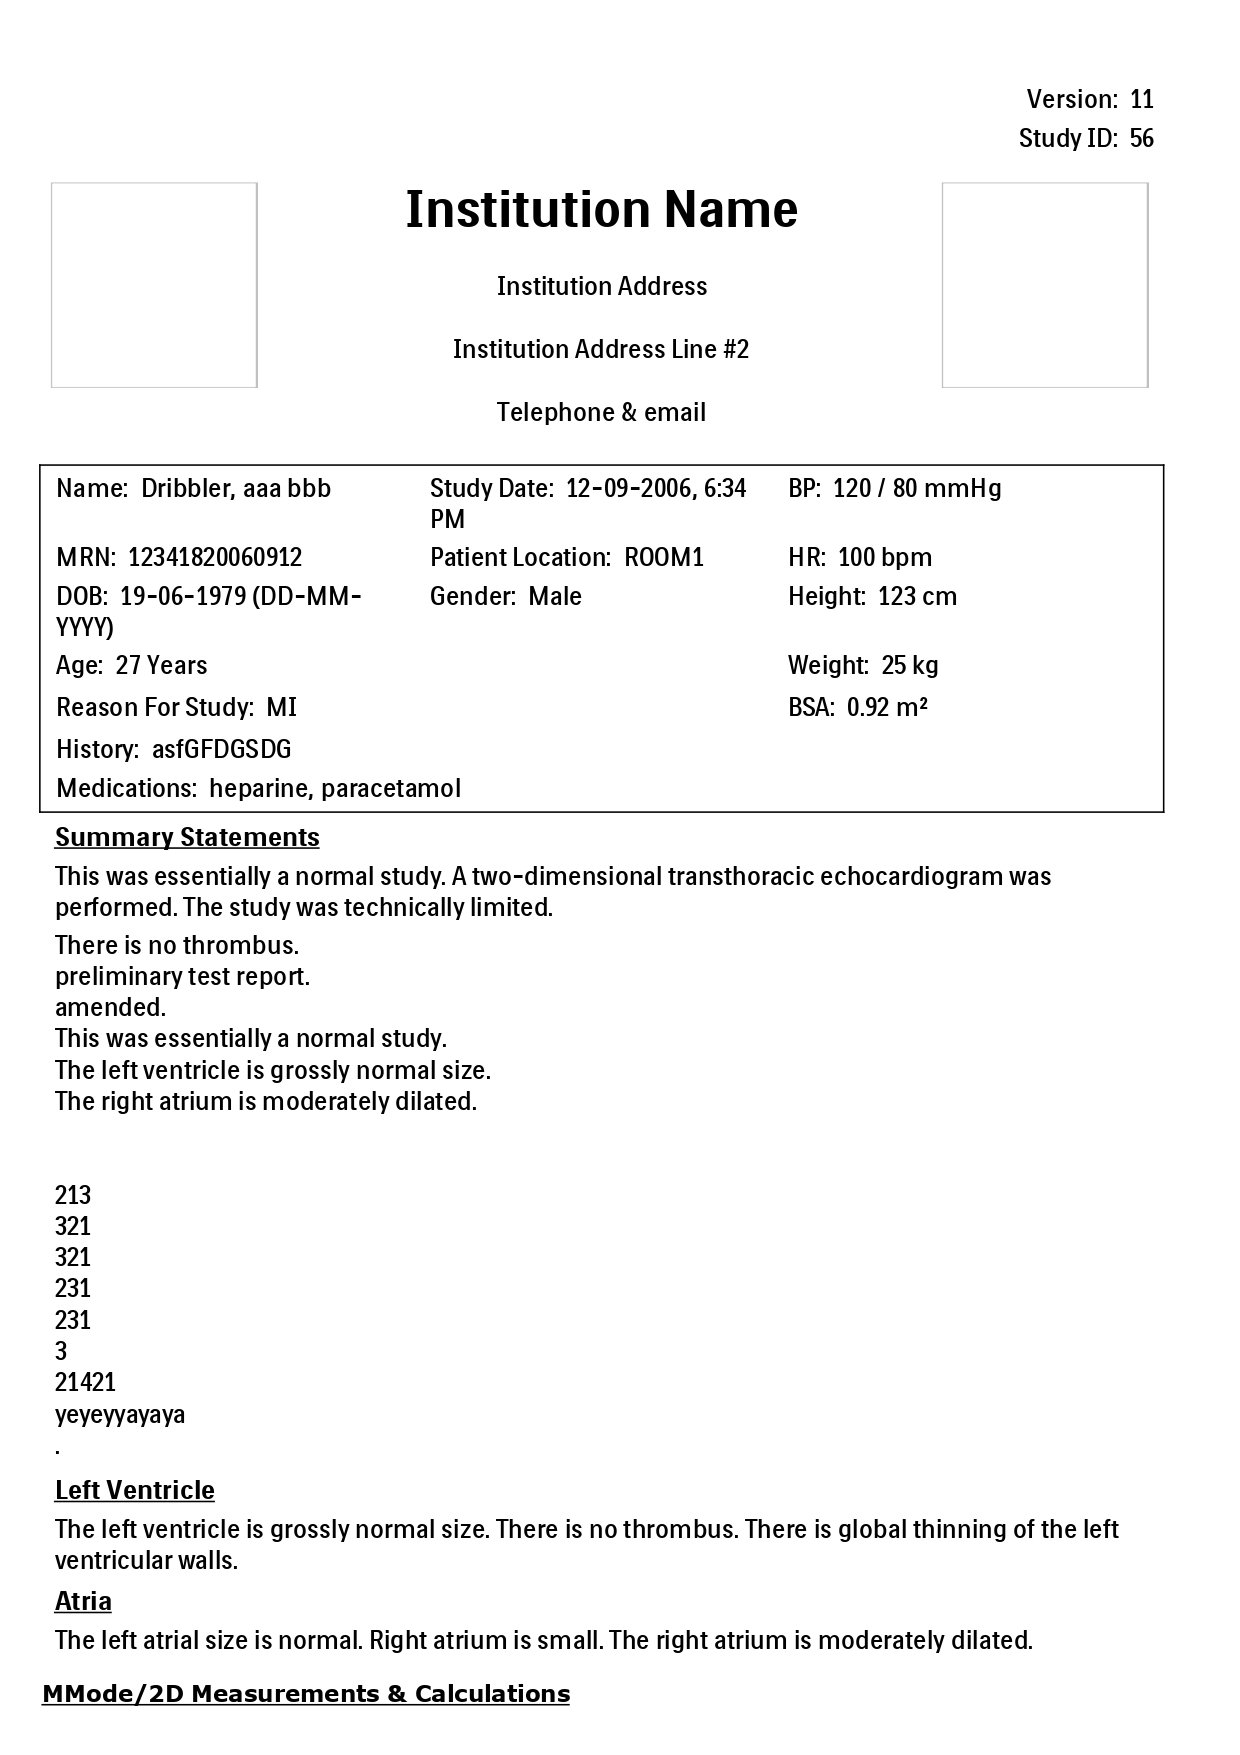

In [6]:
import pkg_resources
test_image_path = visual.pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
visual.display_images(visual.BinaryToImage().transform(bin_df))

## Define pipeline

In [8]:
binary_to_image = visual.BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR)

img_to_hocr = visual.ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = visual.HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner =  visual.VisualDocumentNer()\
    .pretrained("lilt_roberta_funsd_v1", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")

rel_extractor = visual.FormRelationExtractor() \
    .setInputCol("entities") \
    .setOutputCol("relations")

draw_key_values = visual.ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("relations") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(visual.Color.red)

draw_ner = visual.ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_ner") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(visual.Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    rel_extractor,
    draw_key_values,
    draw_ner
])

lilt_roberta_funsd_v1 download started this may take some time.
Approximate size to download 419.6 MB


## Call pipeline

In [9]:
results = pipeline.transform(bin_df).cache()

## Show resulst

In [10]:
results.select(f.explode("relations.result")).show(20, False)

+--------------------------------------------+
|col                                         |
+--------------------------------------------+
|name : dribbler , bbb                       |
|study date : 12 - 09 - 2006 , 6 : 34        |
|bp : 120 / 80 mmhg                          |
|mrn : 12341820060912                        |
|patient location : room                     |
|hr : 100 bpm                                |
|dob : 19 - 06 - 1979                        |
|gender : male                               |
|height : 123 cm                             |
|age : 27 years                              |
|weight : 25 kg                              |
|reason for study : mi                       |
|bsa : 0 . 92 m                              |
|history : asfgfdgsdg                        |
|medications : heparine , paracetamol        |
|performed .: the study technically limited .|
|.: no                                       |
+--------------------------------------------+



In [11]:
results.withColumn("metadata", f.explode("relations.metadata")) \
 .select(f.col("metadata.entity1").alias("key"), f.col("metadata.entity2").alias("value")).show(20, False)

+------------------+-------------------------------+
|key               |value                          |
+------------------+-------------------------------+
|name :            |dribbler , bbb                 |
|study date :      |12 - 09 - 2006 , 6 : 34        |
|bp :              |120 / 80 mmhg                  |
|mrn :             |12341820060912                 |
|patient location :|room                           |
|hr :              |100 bpm                        |
|dob :             |19 - 06 - 1979                 |
|gender :          |male                           |
|height :          |123 cm                         |
|age :             |27 years                       |
|weight :          |25 kg                          |
|reason for study :|mi                             |
|bsa :             |0 . 92 m                       |
|history :         |asfgfdgsdg                     |
|medications :     |heparine , paracetamol         |
|performed .       |the study technically limi

### Show NER results


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


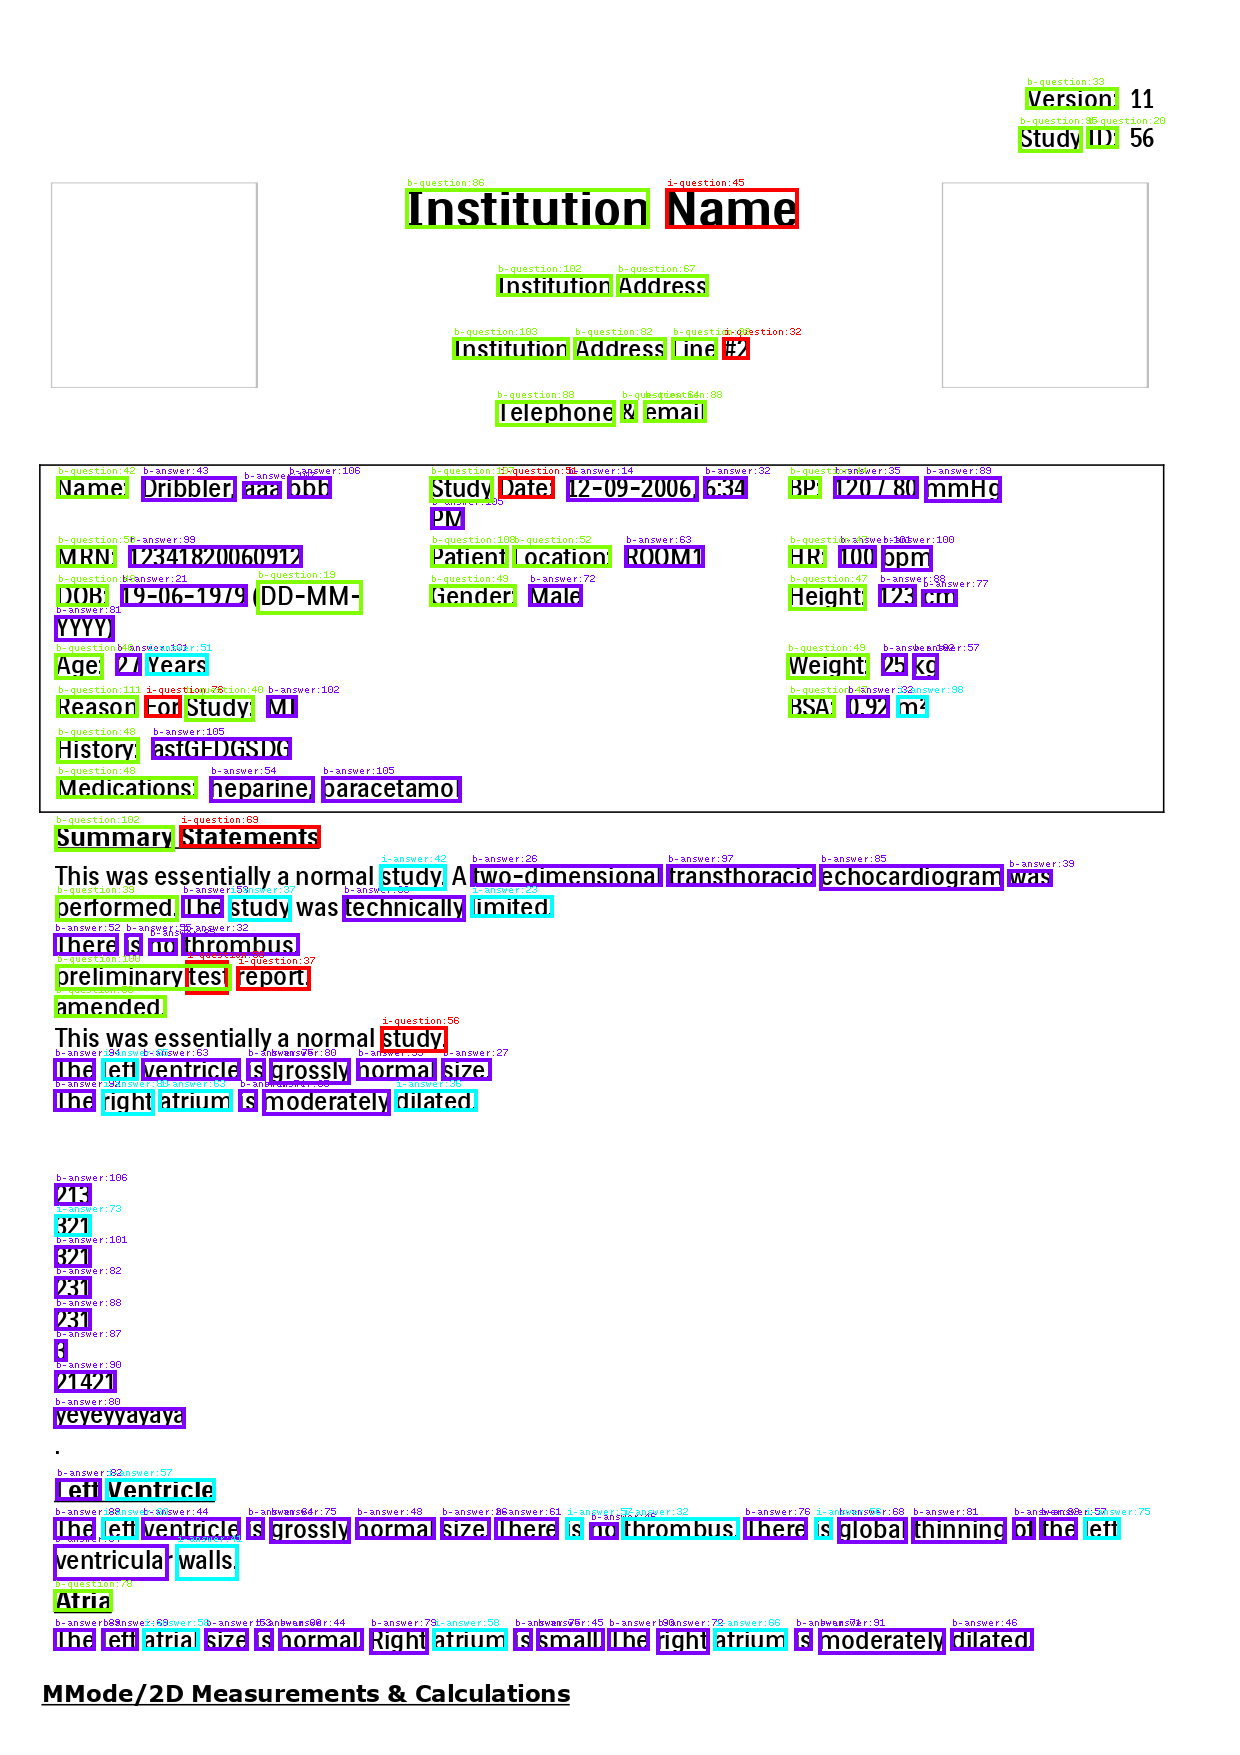

In [12]:
visual.display_images(results, "image_with_ner")

### Show final annotations


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


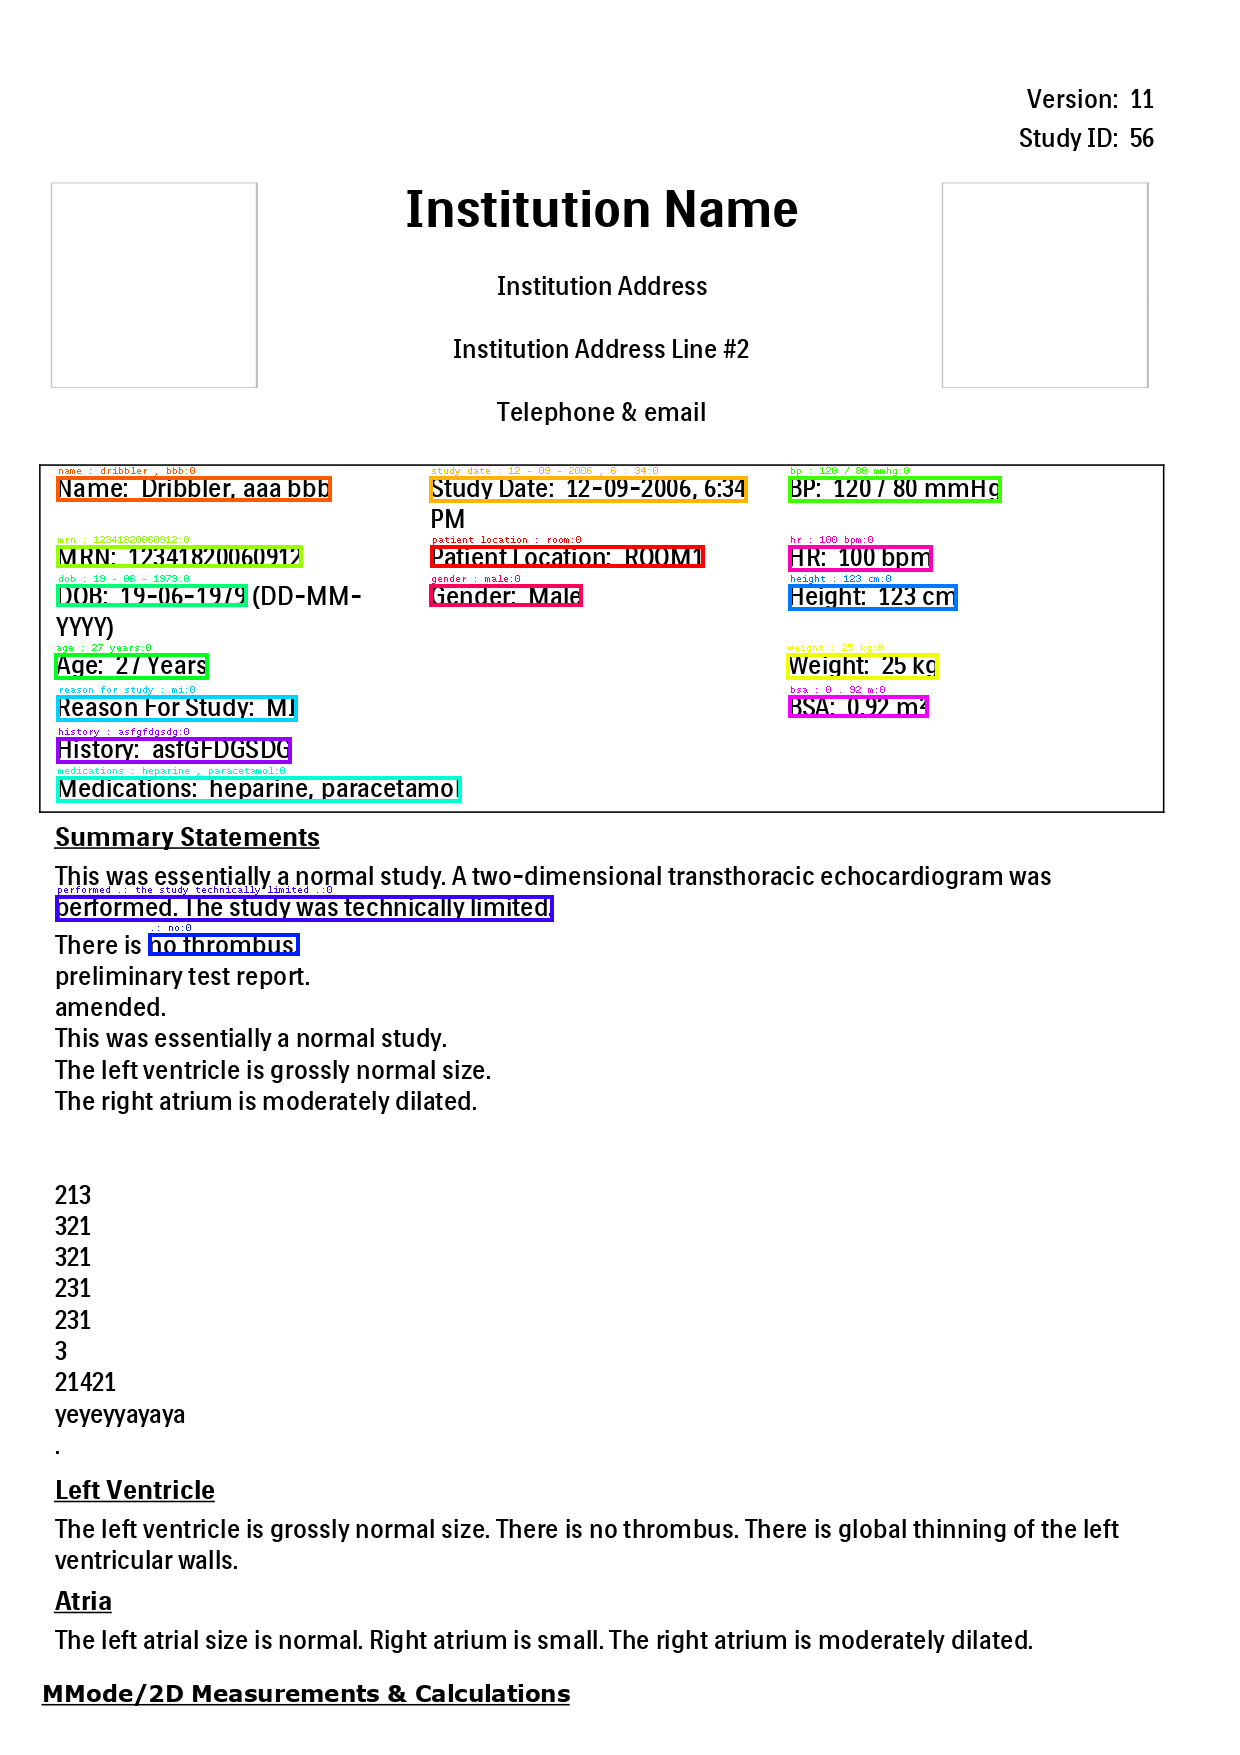

In [13]:
visual.display_images(results, "image_with_annotations")